In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

from cycler import cycler
COLORS = ['#242482', '#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319', '#F00D2C']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

In [3]:
# load data from text
data = np.loadtxt('data/lec25.txt')

num_points = data.shape[0]

# Shuffle the data to remove bias with respect to order
I_perm = np.random.permutation(len(data))
data = data[I_perm, :]

# Extract input and outputs
x = data[:, 0:2]

# The class data
y = data[:, 2]

In [4]:
# turn 0,1 to color strings just for plotting
y_color = []
for i in range(num_points):
    y_color.append(COLORS[int(y[i])])

Text(0, 0.5, 'x2')

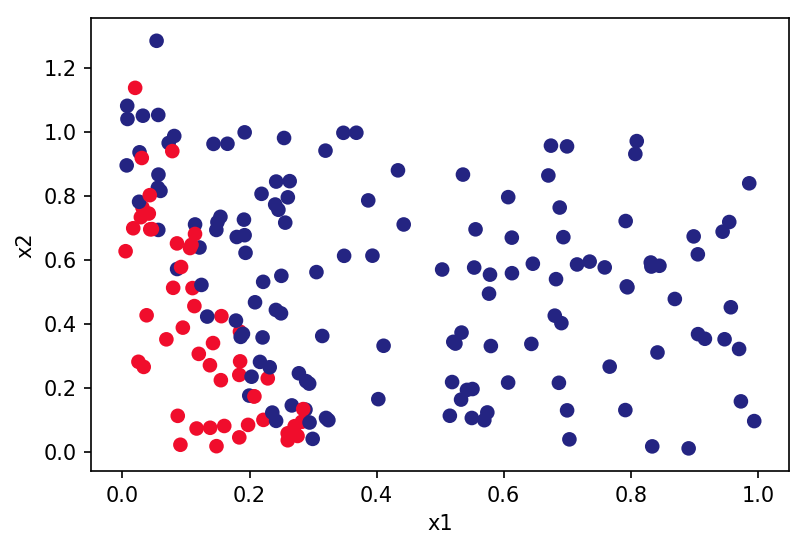

In [6]:
mpl.rcParams['figure.dpi']= 150
plt.scatter(x[:,0], x[:,1], c=y_color)
plt.xlabel('x1')
plt.ylabel('x2')

In [7]:
class_counts = np.bincount(y.astype(int))
print("Counts:")
print(class_counts)

print("\nPercentages:")
print(100.0*class_counts/len(y))

Counts:
[137  50]

Percentages:
[73.26203209 26.73796791]


In [8]:
from matplotlib.colors import ListedColormap

# Predict every point in the plane - you can ignore this part if you want
def plot_plane(model):
    # Form all combinations of points in the plane
    x1_plot = np.linspace(np.min(x[:,0])-0.1, np.max(x[:, 0])+0.1, 200)
    x2_plot = np.linspace(np.min(x[:,1])-0.1, np.max(x[:, 1])+0.1, 200)
    xx1, xx2 = np.meshgrid(x1_plot, x2_plot)
    # Flatten xx1 and xx2 to a list of points
    x_plot = np.array([xx1.ravel(), xx2.ravel()]).transpose()

    # classify each point
    y_plot = model.predict(x_plot)

    # shape into matrix so we can color the plane
    y_plot = y_plot.reshape(xx1.shape)
    # plot classification at each point as a colored region
    plt.pcolormesh(xx1, xx2, y_plot, cmap=ListedColormap(COLORS))

    # Plot the original data
    plt.scatter(x[:,0], x[:,1], marker='^', edgecolors='k', linewidth=0.75, c=y_color)
    plt.xlabel('X1')
    plt.ylabel('X2')
    
def report_performance(model, x_train, y_train):
    model.fit(x_train, y_train)
    y_valid_model = model.predict(x_valid)
    plot_plane(model)
    print(" Accuracy = " + str(accuracy_score(y_valid, y_valid_model)))
    print("Precision = " + str(precision_score(y_valid, y_valid_model)))
    print("   Recall = " + str(recall_score(y_valid, y_valid_model)))
    print("       F1 = " + str(f1_score(y_valid, y_valid_model)))

# Results ignoring class imbalance

In [9]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

num_train = int(num_points*0.8*0.8)
num_valid = int(num_points*0.8*0.2)

# Extract
x_train = x[:num_train]
y_train = y[:num_train]
    
x_valid = x[num_train:num_train+num_valid]
y_valid = y[num_train:num_train+num_valid]

x_test = x[num_train+num_valid:]
y_test = y[num_train+num_valid:]

# Normalize data
# IMPORTANT: Normalization parameters must be derived from training data
mu_x = np.mean(x_train, axis = 0)
sig_x = np.std(x_train, axis = 0)

x_train = (x_train - mu_x)/sig_x
x_valid = (x_valid - mu_x)/sig_x
x_test = (x_test - mu_x)/sig_x
x = (x - mu_x)/sig_x

 Accuracy = 0.8275862068965517
Precision = 0.8
   Recall = 0.7272727272727273
       F1 = 0.761904761904762


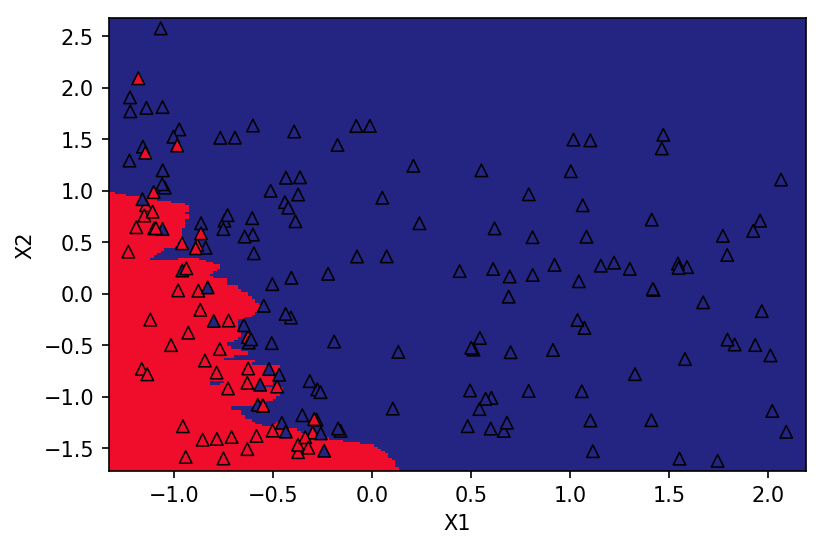

In [10]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
report_performance(model, x_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Accuracy = 0.7931034482758621
Precision = 0.7777777777777778
   Recall = 0.6363636363636364
       F1 = 0.7000000000000001


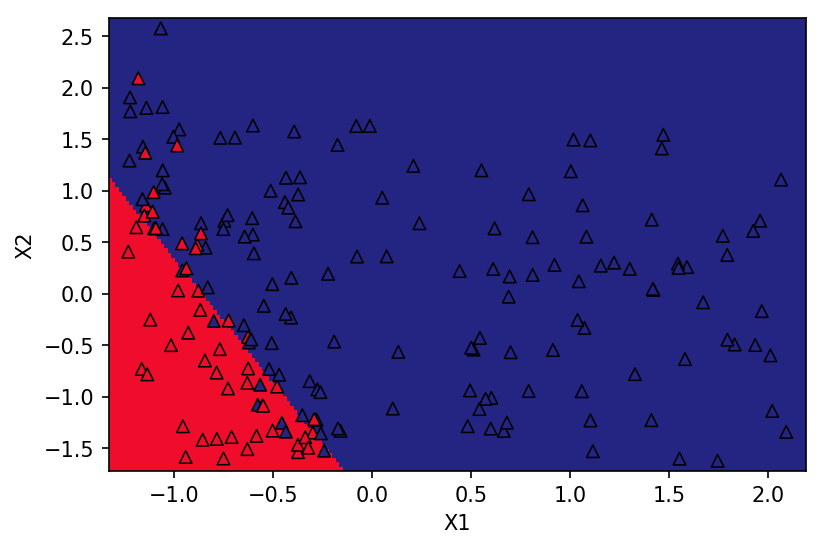

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
report_performance(model, x_train, y_train)

 Accuracy = 0.7931034482758621
Precision = 0.8571428571428571
   Recall = 0.5454545454545454
       F1 = 0.6666666666666665


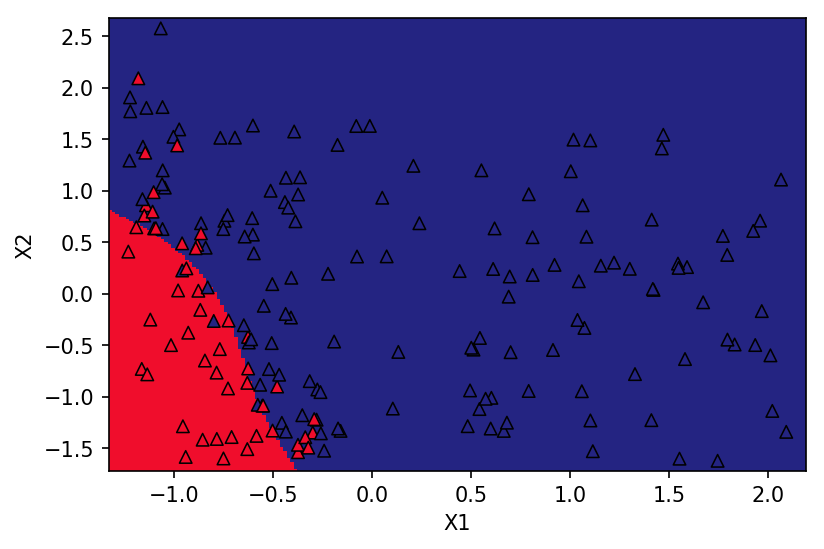

In [12]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
report_performance(model, x_train, y_train)

 Accuracy = 0.8620689655172413
Precision = 0.7692307692307693
   Recall = 0.9090909090909091
       F1 = 0.8333333333333333


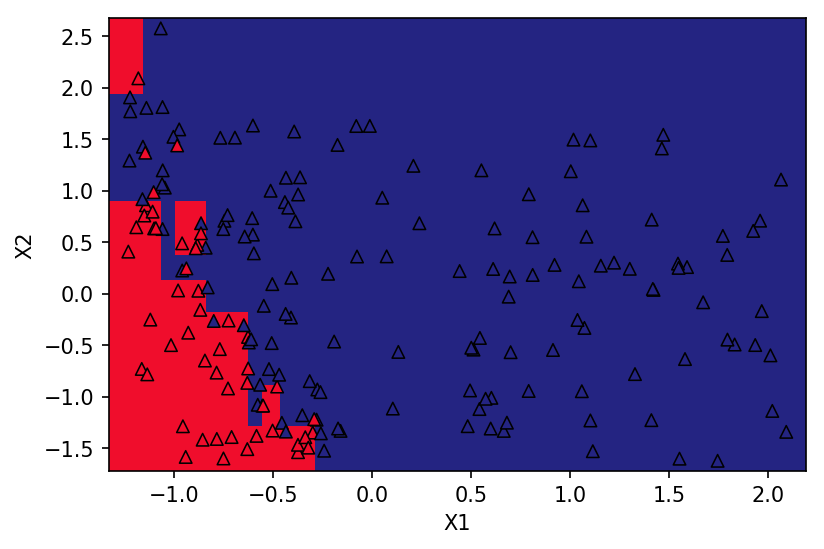

In [13]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy')
report_performance(model, x_train, y_train)

# Reweigh data.

 Accuracy = 0.896551724137931
Precision = 0.8333333333333334
   Recall = 0.9090909090909091
       F1 = 0.8695652173913043


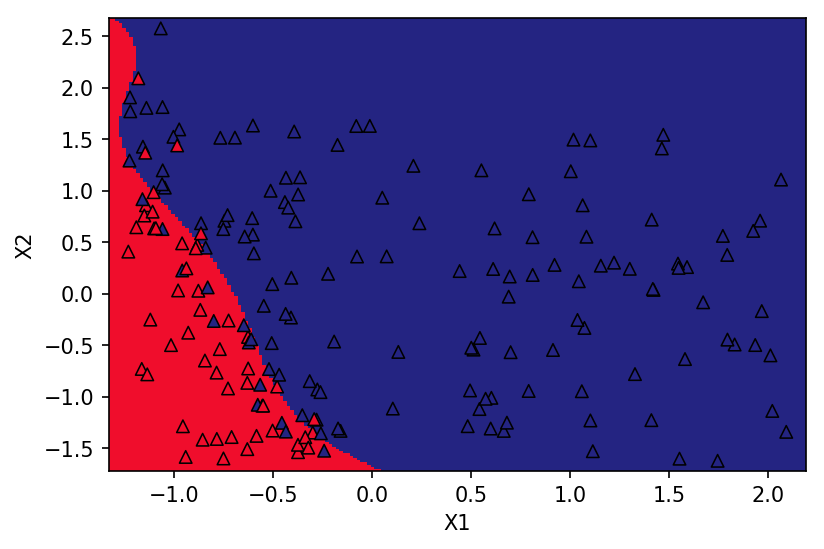

In [14]:
model = SVC(kernel='rbf', class_weight = {0: 0.3*num_train, 1: 0.7*num_train})
report_performance(model, x_train, y_train)    

WEIGHT = 0.1
 Accuracy = 0.8620689655172413
Precision = 0.7692307692307693
   Recall = 0.9090909090909091
       F1 = 0.8333333333333333


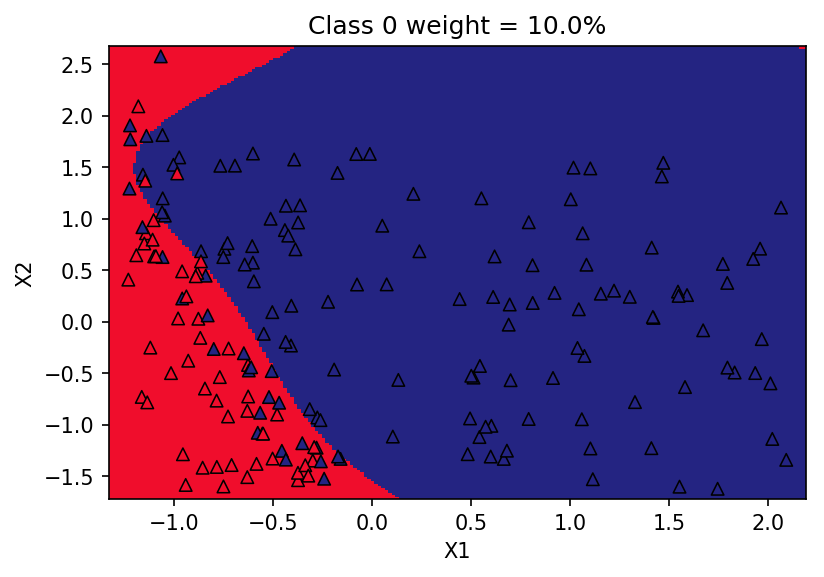

WEIGHT = 0.2
 Accuracy = 0.896551724137931
Precision = 0.8333333333333334
   Recall = 0.9090909090909091
       F1 = 0.8695652173913043


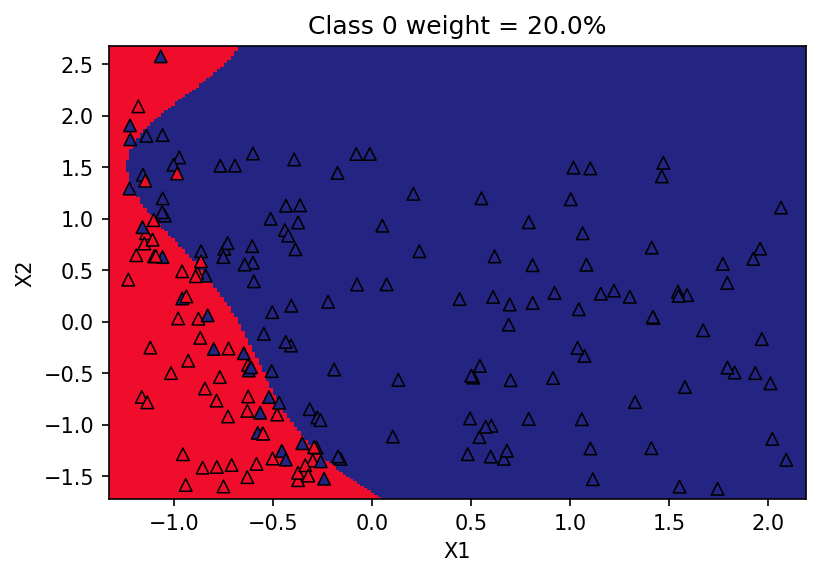

WEIGHT = 0.30000000000000004
 Accuracy = 0.896551724137931
Precision = 0.8333333333333334
   Recall = 0.9090909090909091
       F1 = 0.8695652173913043


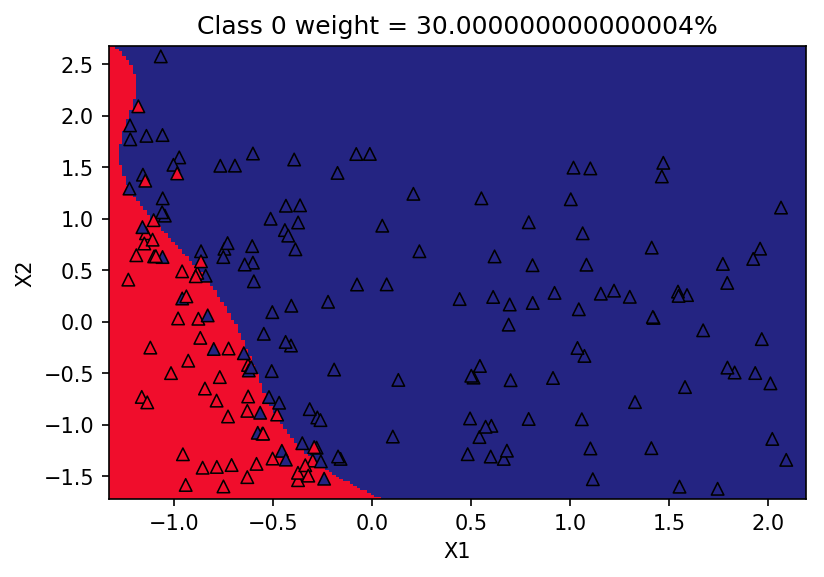

WEIGHT = 0.4
 Accuracy = 0.8620689655172413
Precision = 0.8181818181818182
   Recall = 0.8181818181818182
       F1 = 0.8181818181818182


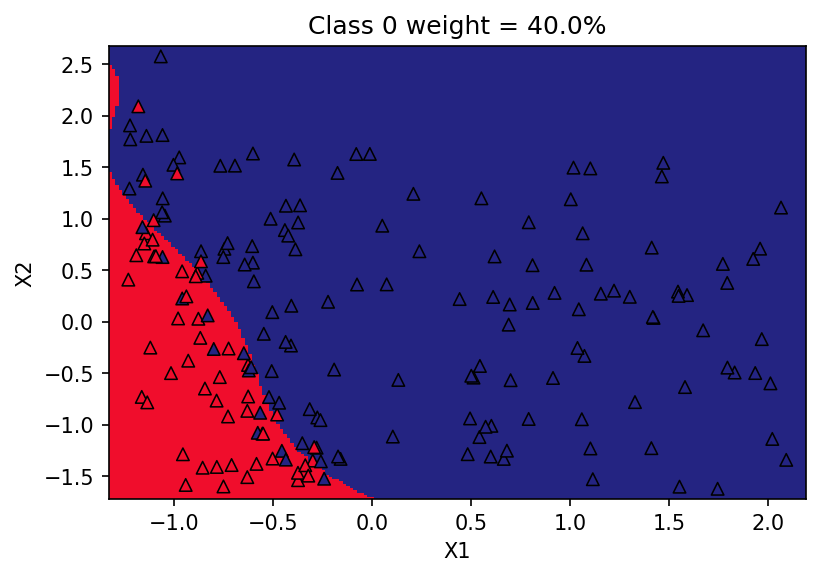

WEIGHT = 0.5
 Accuracy = 0.7931034482758621
Precision = 0.7777777777777778
   Recall = 0.6363636363636364
       F1 = 0.7000000000000001


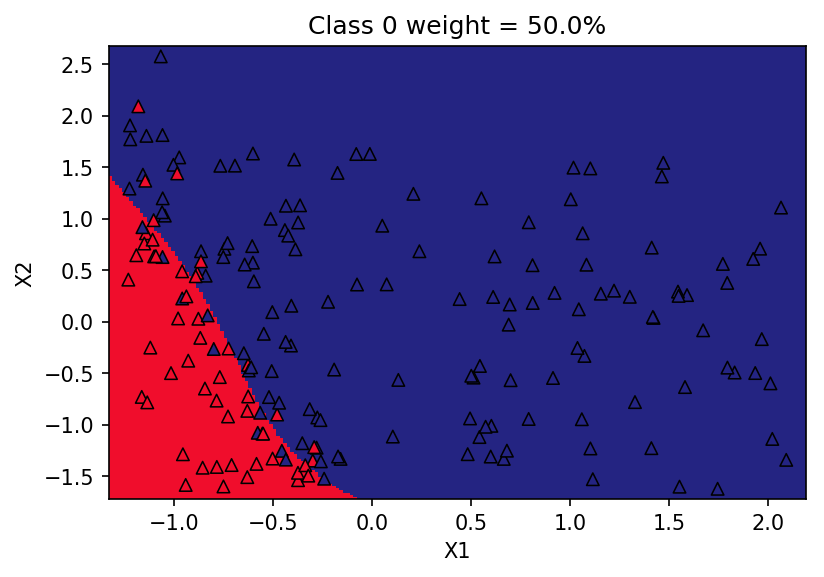

WEIGHT = 0.6
 Accuracy = 0.7931034482758621
Precision = 0.7777777777777778
   Recall = 0.6363636363636364
       F1 = 0.7000000000000001


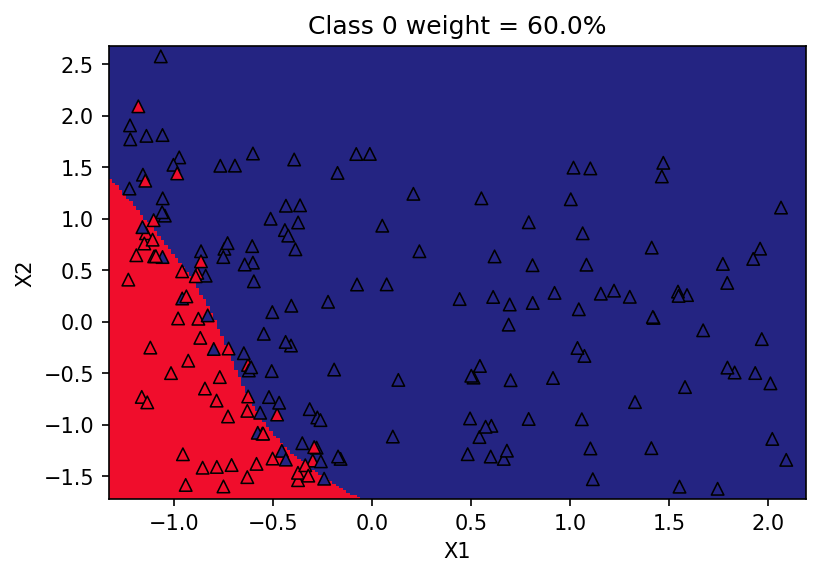

WEIGHT = 0.7000000000000001
 Accuracy = 0.7931034482758621
Precision = 0.8571428571428571
   Recall = 0.5454545454545454
       F1 = 0.6666666666666665


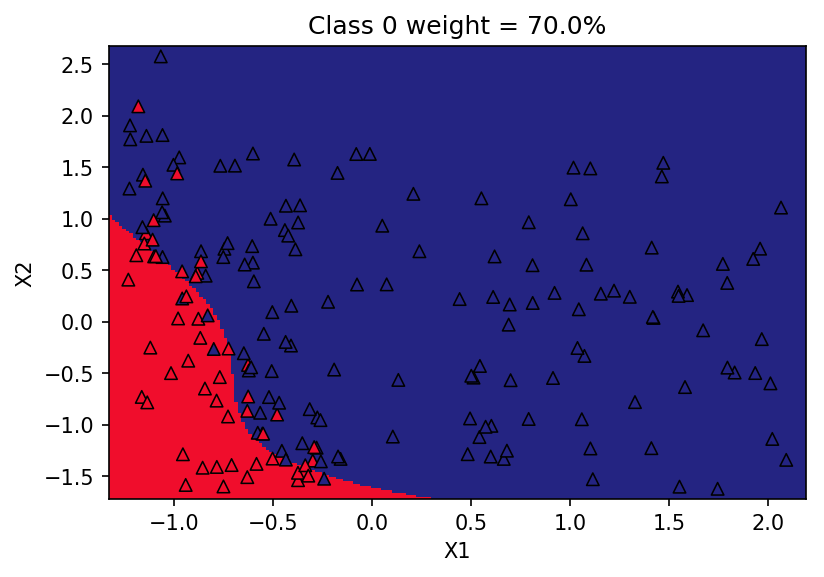

WEIGHT = 0.8
 Accuracy = 0.7931034482758621
Precision = 0.8571428571428571
   Recall = 0.5454545454545454
       F1 = 0.6666666666666665


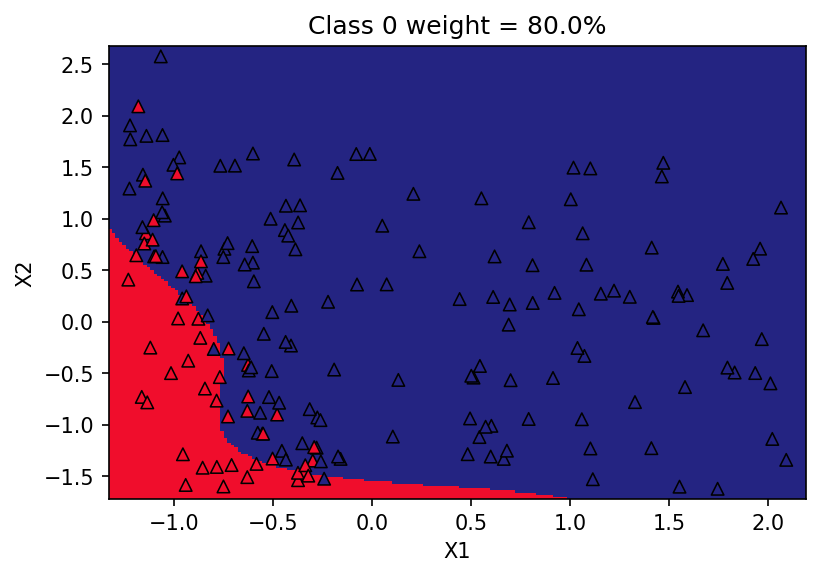

WEIGHT = 0.9
 Accuracy = 0.7586206896551724
Precision = 1.0
   Recall = 0.36363636363636365
       F1 = 0.5333333333333333


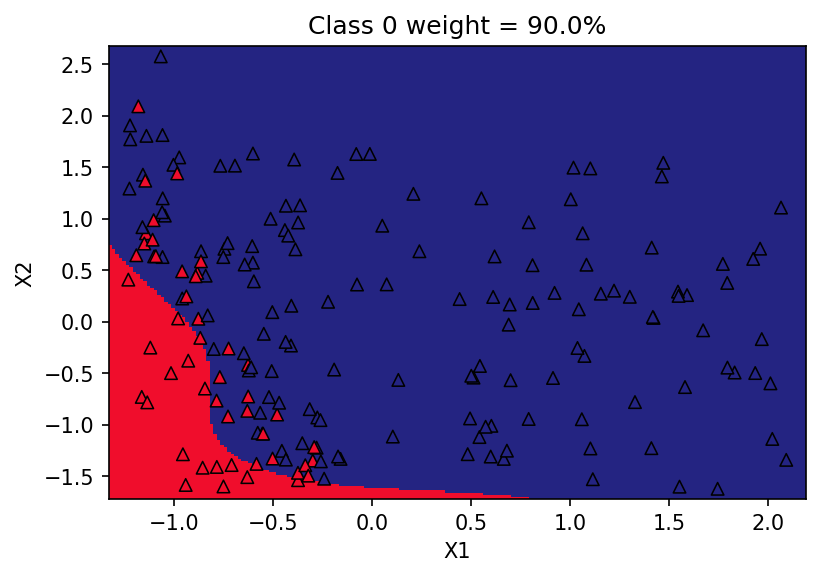

WEIGHT = 1.0
 Accuracy = 0.6206896551724138
Precision = 0.0
   Recall = 0.0
       F1 = 0.0


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


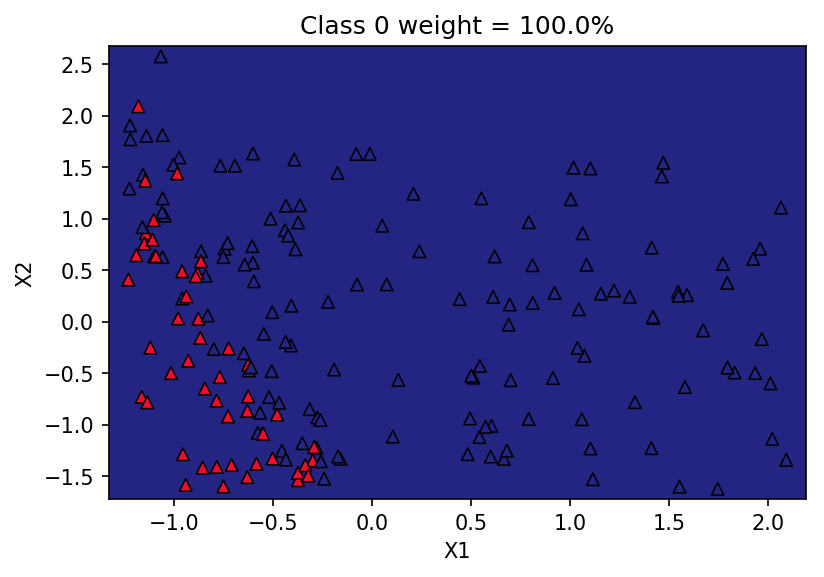

In [15]:
class0_weights = np.linspace(0.1, 1, 10)

for w in class0_weights:
    model = SVC(kernel='rbf', class_weight = {0: w*num_train, 1: (1-w)*num_train})
    print("WEIGHT = " + str(w))
    report_performance(model, x_train, y_train)    
    plt.title("Class 0 weight = " + str(100.0*w) + "%" )
    plt.show()

You can optimize this, or use the "balanced" weighting as a good rule of thumb. This weights each point inversely proportional to the size of the class the point belongs to.

 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


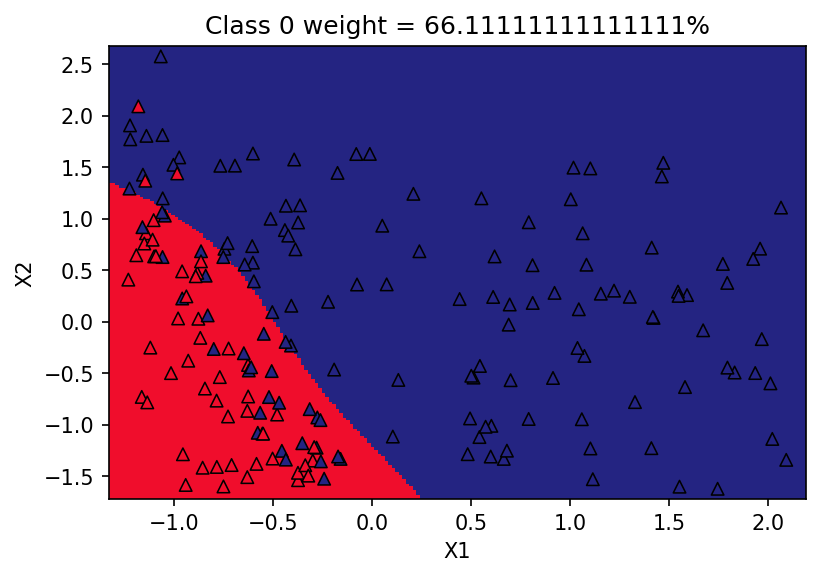

In [16]:
model = SVC(kernel='rbf', class_weight = 'balanced')
report_performance(model, x_train, y_train)
plt.title("Class 0 weight = " + str(100.0*model.class_weight_[0]) + "%" )
plt.show()

Same goes for the Logistic Regression Model and classification trees

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


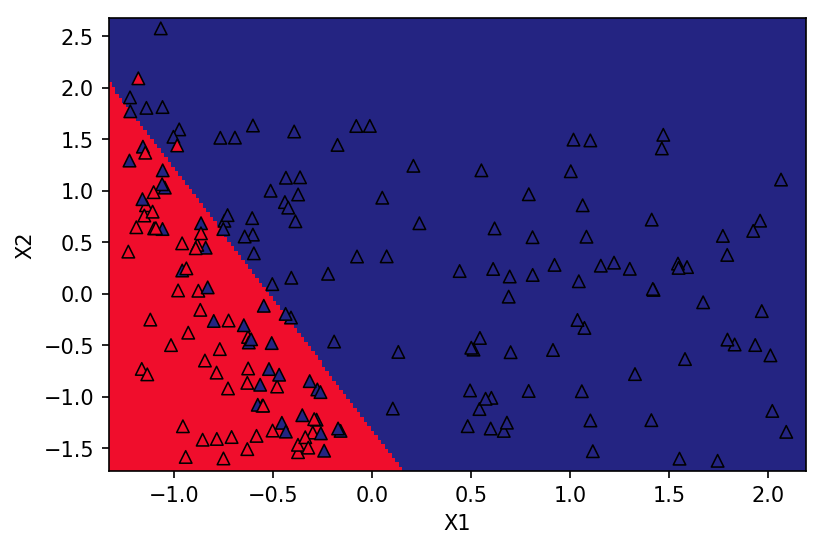

In [17]:
model = LogisticRegression(class_weight = 'balanced')
report_performance(model, x_train, y_train)

 Accuracy = 0.8275862068965517
Precision = 0.8
   Recall = 0.7272727272727273
       F1 = 0.761904761904762


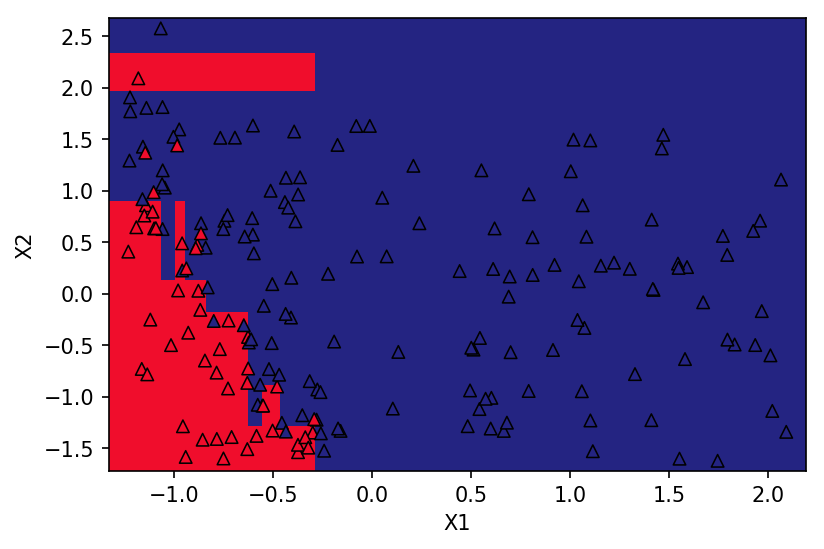

In [18]:
model = DecisionTreeClassifier(criterion='entropy', class_weight = 'balanced')
report_performance(model, x_train, y_train)

There's no change the the classification tree performance.

# Over and undersampling

In [20]:
# Separate training data into classes

I_0 = y_train == 0
I_1 = y_train == 1

x_train_0 = x_train[I_0, :]
x_train_1 = x_train[I_1, :]

y_train_0 = y_train[I_0] #(all 0s)
y_train_1 = y_train[I_1] #(all 1s)

n0 = len(y_train_0)
n1 = len(y_train_1)

print("Size of class 0 in training data: " + str(n0))
print("Size of class 1 in training data: " + str(n1))

Size of class 0 in training data: 90
Size of class 1 in training data: 29


## Undersampling

In [21]:
# Undersample majority class - select only n1 for class 0 (randomly, without replacement) 88 -> 31
I_train_0 = np.random.choice(n0, n1, replace = False)
x_train_0_undersample = x_train_0[I_train_0, :]
y_train_0_undersample = y_train_0[I_train_0] #(all 0s)

# Put the data back together: all the class 1 data and the undersampled class 0 data
x_train_undersample = np.concatenate([x_train_0_undersample, x_train_1])
y_train_undersample = np.concatenate([y_train_0_undersample, y_train_1])
print(x_train_undersample.shape)
print(y_train_undersample.shape)

(58, 2)
(58,)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


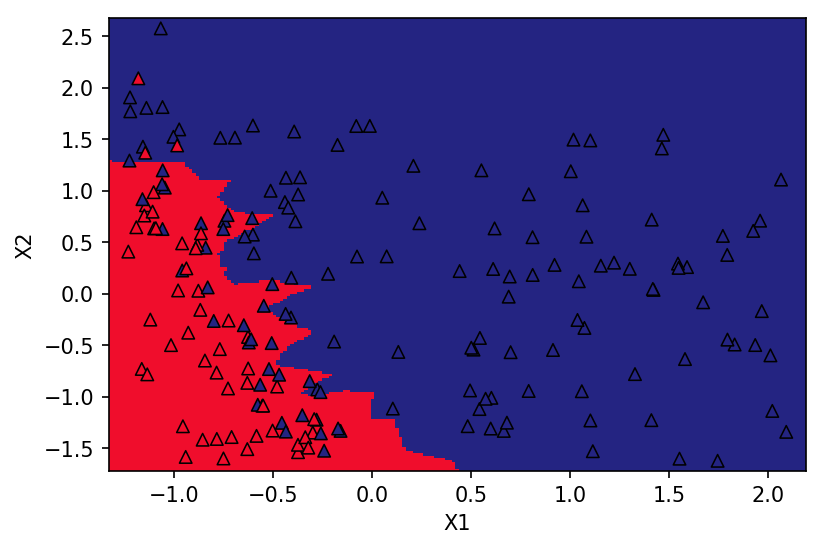

In [22]:
# Train and validate some models
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
report_performance(model, x_train_undersample, y_train_undersample)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


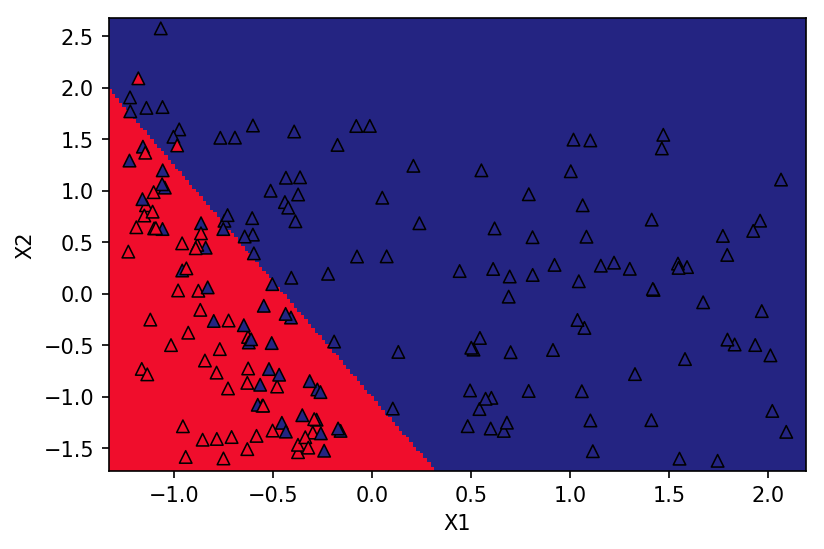

In [23]:
model = LogisticRegression()
report_performance(model, x_train_undersample, y_train_undersample)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


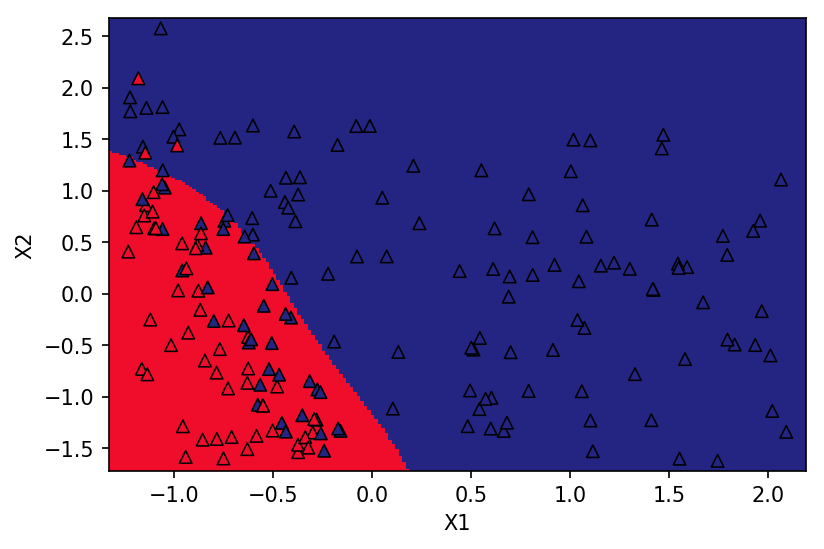

In [24]:
model = SVC(kernel='rbf')
report_performance(model, x_train_undersample, y_train_undersample)

 Accuracy = 0.8275862068965517
Precision = 0.8
   Recall = 0.7272727272727273
       F1 = 0.761904761904762


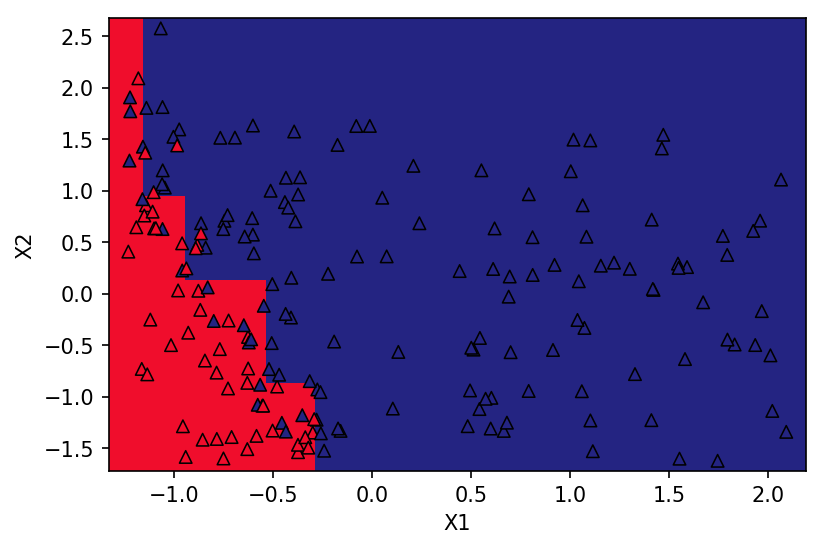

In [25]:
model = DecisionTreeClassifier(criterion='entropy')
report_performance(model, x_train_undersample, y_train_undersample)

## Oversample

In [26]:
# oversample: sample n0 samples for class 1 (with replacement) 31 -> 88

I_train_1 = np.random.choice(n1, n0, replace = True)
print(I_train_1)

[ 7  7  1 28 20 23 25 21  4  0 25 16 16 23  4 19 10 26 15 19 20  8 15 19
 13  2  5  1  3 23  8 18  6 22 19  4 23 11  5 11 25 19  3 14  0 23  7  4
 27 18  2  0 11  0  4  3 23 20  4 16 19 13 20 17 20  5  8 17 19  2 19 17
 17  1  6  0 25 18 28 16  2  0 26  3 17  7 27 28 13 14]


In [27]:
x_train_1_oversample = x_train_1[I_train_1, :]
y_train_1_oversample = y_train_1[I_train_1] #(all 1s)

# Put the data back together: all the class 0 data and the oversampled class 0 data
x_train_oversample = np.concatenate([x_train_1_oversample, x_train_0])
y_train_oversample = np.concatenate([y_train_1_oversample, y_train_0])
print(x_train_oversample.shape)
print(y_train_oversample.shape)

(180, 2)
(180,)


 Accuracy = 0.896551724137931
Precision = 0.8333333333333334
   Recall = 0.9090909090909091
       F1 = 0.8695652173913043


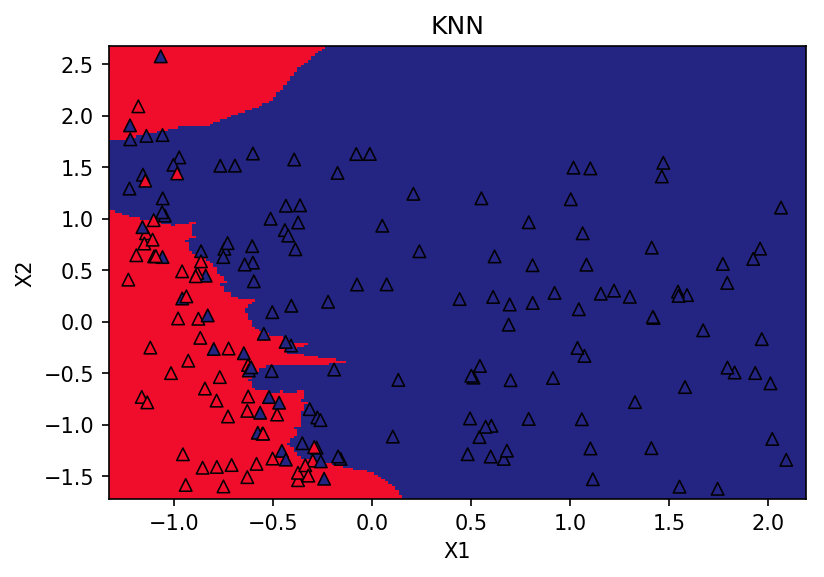

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


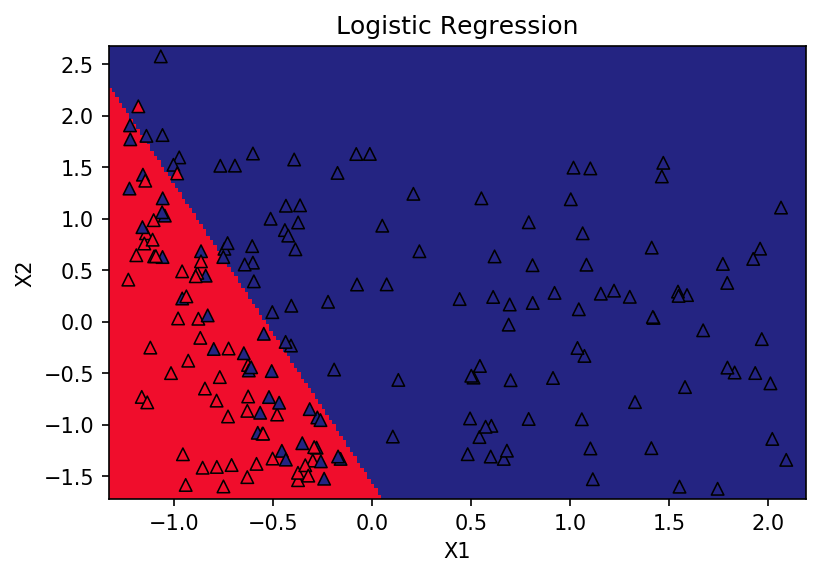

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 Accuracy = 0.8620689655172413
Precision = 0.7692307692307693
   Recall = 0.9090909090909091
       F1 = 0.8333333333333333


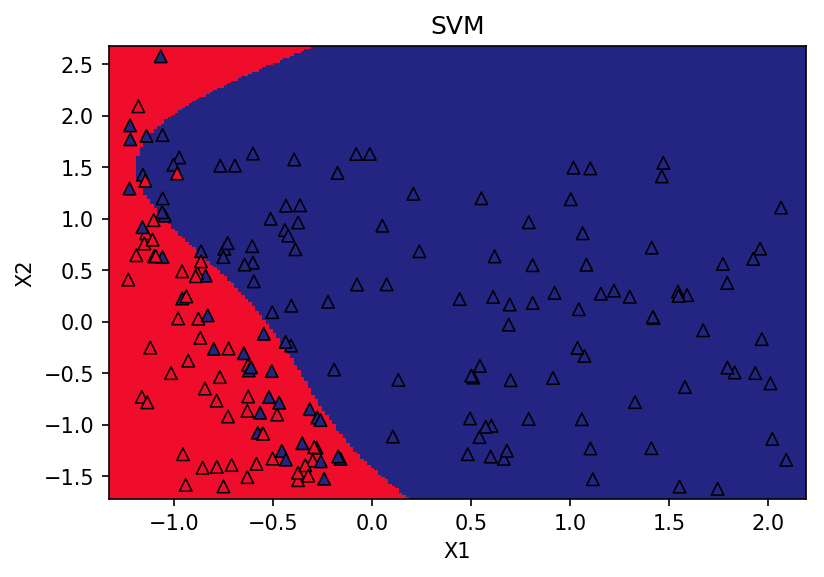

 Accuracy = 0.7931034482758621
Precision = 0.7777777777777778
   Recall = 0.6363636363636364
       F1 = 0.7000000000000001


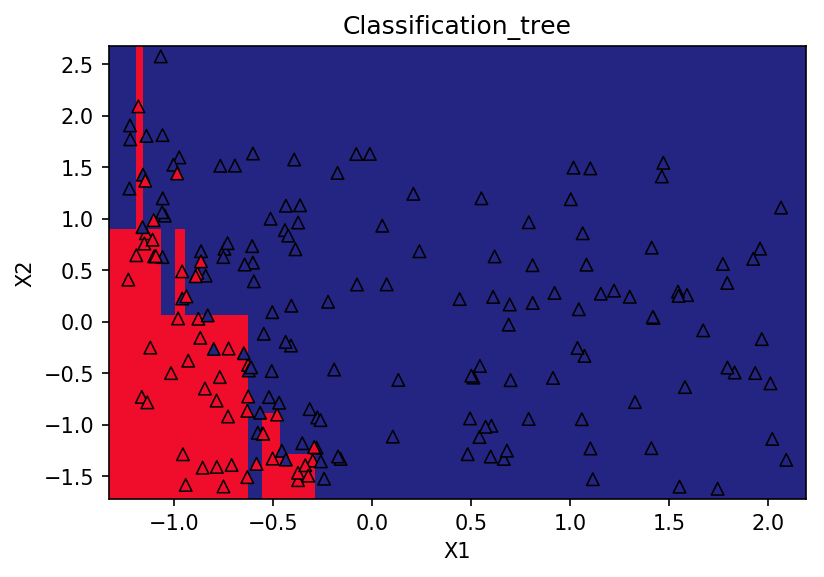

In [28]:
# Train some models
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
report_performance(model, x_train_oversample, y_train_oversample)
plt.title('KNN')
plt.show()

model = LogisticRegression()
report_performance(model, x_train_oversample, y_train_oversample)
plt.title('Logistic Regression')
plt.show()

model = SVC(kernel='rbf')
report_performance(model, x_train_oversample, y_train_oversample)
plt.title('SVM')
plt.show()

model = DecisionTreeClassifier(criterion='entropy')
report_performance(model, x_train_oversample, y_train_oversample)
plt.title('Classification_tree')
plt.show()

# Synthetic Data

We'll use the SMOTE oversampling technique built into `imbalanced-learn`.

In [29]:
!pip install imbalanced-learn

In [30]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
x_train_smote, y_train_smote = sm.fit_resample(x_train, y_train)

print(x_train.shape)
print(x_train_smote.shape)

# how is the imbalance?
print("Resampled 0 class size = " + str(np.sum(y_train_smote == 0)))
print("Resampled 1 class size = " + str(np.sum(y_train_smote == 1)))

Using TensorFlow backend.


(119, 2)
(180, 2)
Resampled 0 class size = 90
Resampled 1 class size = 90


 Accuracy = 0.896551724137931
Precision = 0.8333333333333334
   Recall = 0.9090909090909091
       F1 = 0.8695652173913043


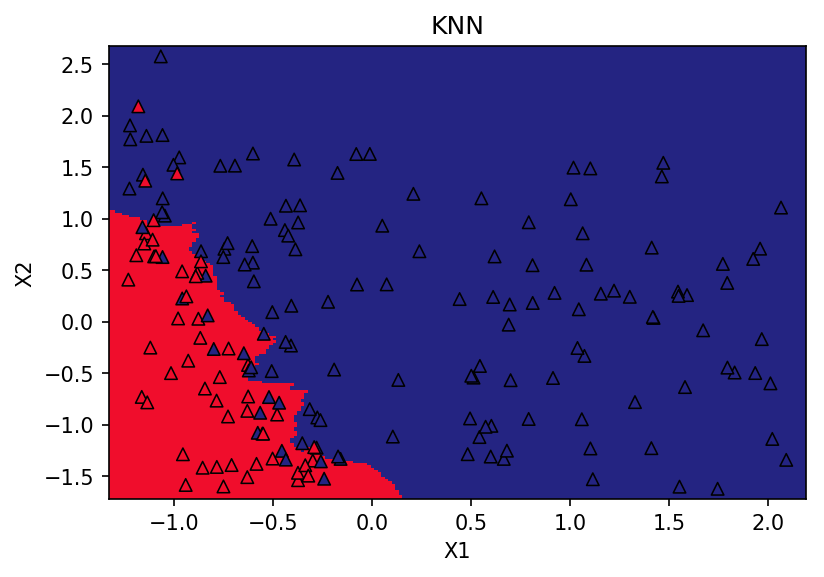

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


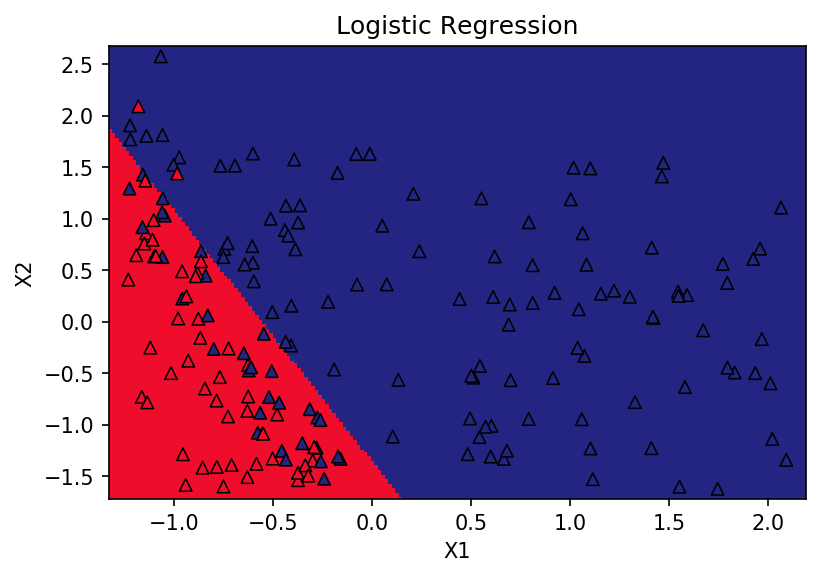

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


 Accuracy = 0.8275862068965517
Precision = 0.7142857142857143
   Recall = 0.9090909090909091
       F1 = 0.8


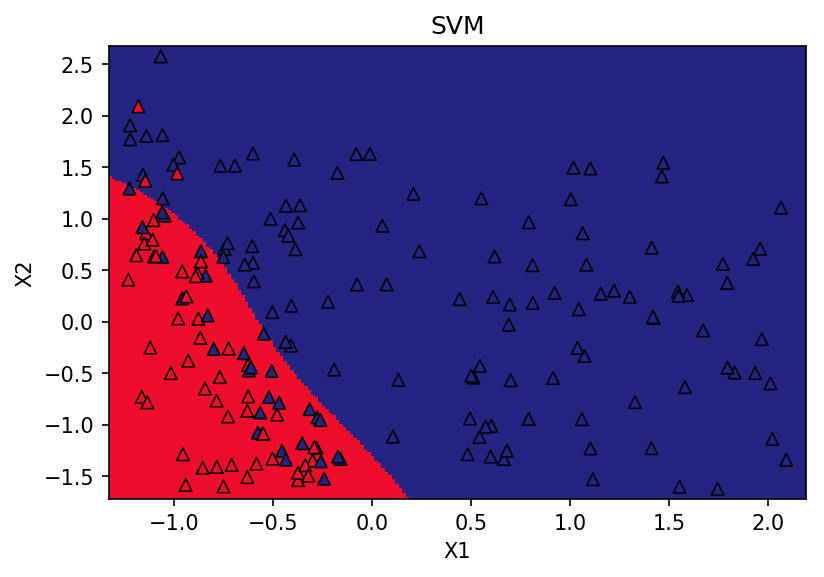

 Accuracy = 0.8620689655172413
Precision = 0.7692307692307693
   Recall = 0.9090909090909091
       F1 = 0.8333333333333333


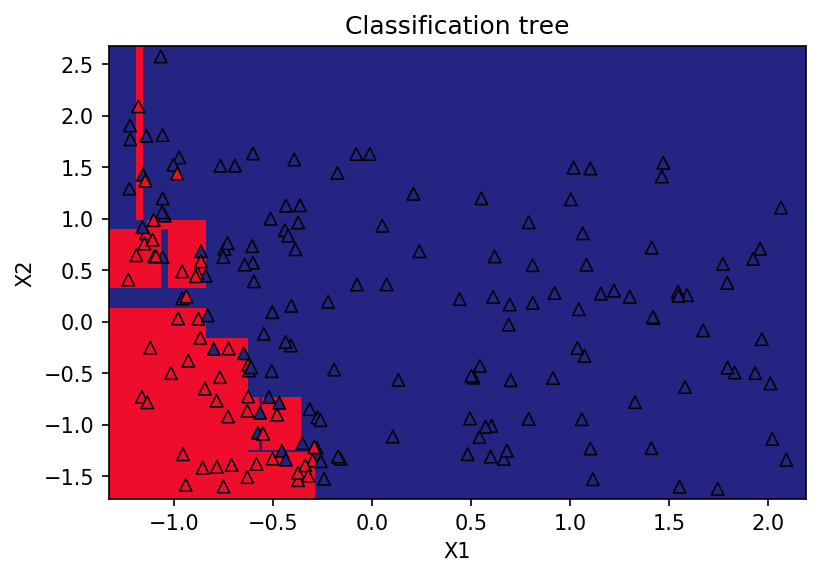

In [31]:
# Train some models
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
report_performance(model, x_train_smote, y_train_smote)
plt.title('KNN')
plt.show()

model = LogisticRegression()
report_performance(model, x_train_smote, y_train_smote)
plt.title('Logistic Regression')
plt.show()

model = SVC(kernel='rbf')
report_performance(model, x_train_smote, y_train_smote)
plt.title('SVM')
plt.show()

model = DecisionTreeClassifier(criterion='entropy')
report_performance(model, x_train_smote, y_train_smote)
plt.title('Classification tree')
plt.show()

Other oversampling / undersampling techniques are implemented in `imbalanced-learn`:
    
https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html
        